# Отборочное соревнование на стажировку в области ML

Необходимо построить модель для прогнозирования оттока клиентов банка. Данные основаны на реальных признаках клиентов, однако для целей соревнования использован синтетический датасет, сгенерированный нейронной сетью на основе реальных распределений.
 

train.csv - обучающий набор данных; Exited является бинарной целью \
test.csv — тестовый набор данных; ваша задача — предсказать вероятность Exited \
sample_submission.csv — образец файла для отправки в правильном формате

### План выполнения

1. [Загрузка данных](#task_1) <a id='task_1_plan'></a>
    - Пропущенные значения
    - Неправильные типы данных
    - Неправильные значения категорий

2. [Предобработка данных](#task_2) <a id='task_2_plan'></a>
    - Поиск дубликатов

3. [Исследовательский анализ данных](#task_3) <a id='task_3_plan'></a>
    - Распределение признаков
    - Портрет ушедшего клиента
    - Какие клиенты не хранят деньги на счету в банке?
    - Поиск выбросов и аномалий
    - Корреляционный анализ

4. [Подготовка данных и обучение моделей](#task_4) <a id='task_4_plan'></a>


### Описание данных

- `Customer ID`: Уникальный идентификатор клиента  
- `Surname`: Фамилия клиента  
- `CreditScore`: Кредитный рейтинг клиента (числовое значение)  
- `Geography`: Страна проживания клиента (Франция, Испания или Германия)  
- `Gender`: Пол клиента (Мужчина или Женщина)  
- `Age`: Возраст клиента  
- `Tenure`: Сколько лет клиент является клиентом банка  
- `Balance`: Баланс на счету клиента  
- `NumOfProducts`: Количество банковских продуктов, которыми пользуется клиент (например, сберегательный счёт, кредитная карта)  
- `HasCrCard`: Есть ли у клиента кредитная карта (1 = да, 0 = нет)  
- `IsActiveMember`: Является ли клиент активным пользователем (1 = да, 0 = нет)  
- `EstimatedSalary`: Примерная зарплата клиента  
- **`Exited`: Ушёл ли клиент из банка (Целевой признак)**

### [Загрузка данных](#task_1_plan) <a id='task_1'></a>

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import phik
import shap
import warnings
import kagglehub

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
from optuna import Trial

from sklearn.metrics import roc_auc_score, f1_score, r2_score

from tqdm.auto import tqdm
from functools import partial

RANDOM_STATE = 42
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 30

In [171]:
# Информация о таблице, наличие пропусков 
def get_dataset(path, sep):
    df = pd.read_csv(path, sep=sep)
    display(df.head())
    df.info()
    display((df.isna().mean() * 100).sort_values(ascending=False).to_frame(name='пропуски_%'))
    return df

In [172]:
# Проверка наличия директории 
def check_dataset(path0, path1, sep):
    if os.path.exists(path0):
        return get_dataset(path0, sep)
    elif os.path.exists(path1):
        return get_dataset(path0, sep)
    else:
        print('неправильный путь к файлу')

In [198]:
path0 = './datasets/train.csv'
path1 = '/kaggle/input/webbee-internship-2025/train.csv' # директория для kagle 

train_customer_churn = check_dataset(path0, path1, sep=',')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15648047.0,Macleod,554.0,France,Female,32.0,3.0,98649.55,1.0,0.0,1.0,177099.71,0.0
1,1,15664681.0,Nnachetam,710.0,France,Male,38.0,9.0,0.00,2.0,0.0,0.0,141872.05,0.0
2,2,15762605.0,Zikoranachidimma,603.0,France,Female,38.0,9.0,136622.42,1.0,1.0,1.0,90212.38,0.0
3,3,15674750.0,Clements,710.0,France,Female,35.0,8.0,0.00,2.0,1.0,0.0,148811.81,0.0
4,4,15706463.0,Pinto,678.0,France,Male,34.0,8.0,0.00,2.0,0.0,0.0,148528.24,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


,пропуски_%
id,0.0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0


Тренировочный датасет имеет 15000 наблюдений, отсутсвуют пропуски. Столбец `id` необходимо перевести в индекс таблицы.

In [199]:
path0 = './datasets/test.csv'
path1 = '/kaggle/input/webbee-internship-2025/test.csv' # директория для kagle 

test_customer_churn = check_dataset(path0, path1, sep=',')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15632848.0,Teng,537.0,Spain,Male,27.0,8.0,119027.28,1.0,1.0,0.0,129964.14
1,15001,15797733.0,Onwuamaeze,646.0,France,Male,41.0,6.0,0.00,2.0,1.0,0.0,158523.02
2,15002,15662085.0,Eluemuno,683.0,France,Female,37.0,9.0,0.00,2.0,1.0,0.0,120892.96
3,15003,15744109.0,Hsing,717.0,France,Male,21.0,5.0,0.00,2.0,1.0,1.0,169781.45
4,15004,15635598.0,Calabrese,662.0,Germany,Male,45.0,4.0,121152.05,1.0,1.0,0.0,116286.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   CustomerId       10000 non-null  float64
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  float64
 10  HasCrCard        10000 non-null  float64
 11  IsActiveMember   10000 non-null  float64
 12  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1015.8+ KB


,пропуски_%
id,0.0
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0


Тестовый датасет имеет 10000 наблюдений, отсутсвуют пропуски.

### [Предобработка данных](#task_2_plan) <a id='task_2'></a>

In [195]:
print('Количество неявных дубликатов:', train_customer_churn.duplicated(subset=train_customer_churn.columns[2:]).sum())

Количество неявных дубликатов: 0


В тренировочном датасете отсутсвуют дубликаты.

In [200]:
train_customer_churn.set_index('id', inplace=True)
test_customer_churn.set_index('id', inplace=True)

Столбец `id` был переведен в индекс таблицы.

### [Исследовательский анализ](#task_3_plan) <a id='task_3'></a>

#### Распределение признаков

In [177]:
# Функция для отображения гистограммы всех признаков
def plt_hist(df):
    plt.figure(figsize=(22, 15))
    i = 1
    cols = df.columns[1:]
    
    for clm_n in cols:
        plt.subplot(4, 3, i)
        if df[clm_n].nunique() <= 20:
            axes = sns.countplot(data=df.iloc[:, 1:], x=clm_n, color='#1F77B4') 
        elif pd.api.types.is_numeric_dtype(df[clm_n]):
            axes = sns.kdeplot(data=df.iloc[:, 1:], x=clm_n, multiple="stack", bw_method=0.1)
        else:
            continue
        axes.set_ylabel('количество')
        i += 1

In [178]:
train_customer_churn.iloc[:, 1:].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000
mean,658.001000,37.737400,5.077600,42918.259637,1.589933,0.778400,0.484867,1.177050e+05,0.200133
std,73.498209,8.153809,2.794083,59874.716430,0.530218,0.415337,0.499788,4.713009e+04,0.400113
min,431.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.158000e+01,0.000000
25%,602.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,8.305543e+04,0.000000
50%,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,1.235473e+05,0.000000
75%,709.000000,42.000000,7.000000,111064.280000,2.000000,1.000000,1.000000,1.564371e+05,0.000000
max,850.000000,74.000000,10.000000,205770.780000,4.000000,1.000000,1.000000,1.557651e+06,1.000000


In [179]:
train_customer_churn.describe(exclude='number')

,Surname,Geography,Gender
count,15000,15000,15000
unique,767,3,2
top,Ch'iu,France,Male
freq,270,8990,8477


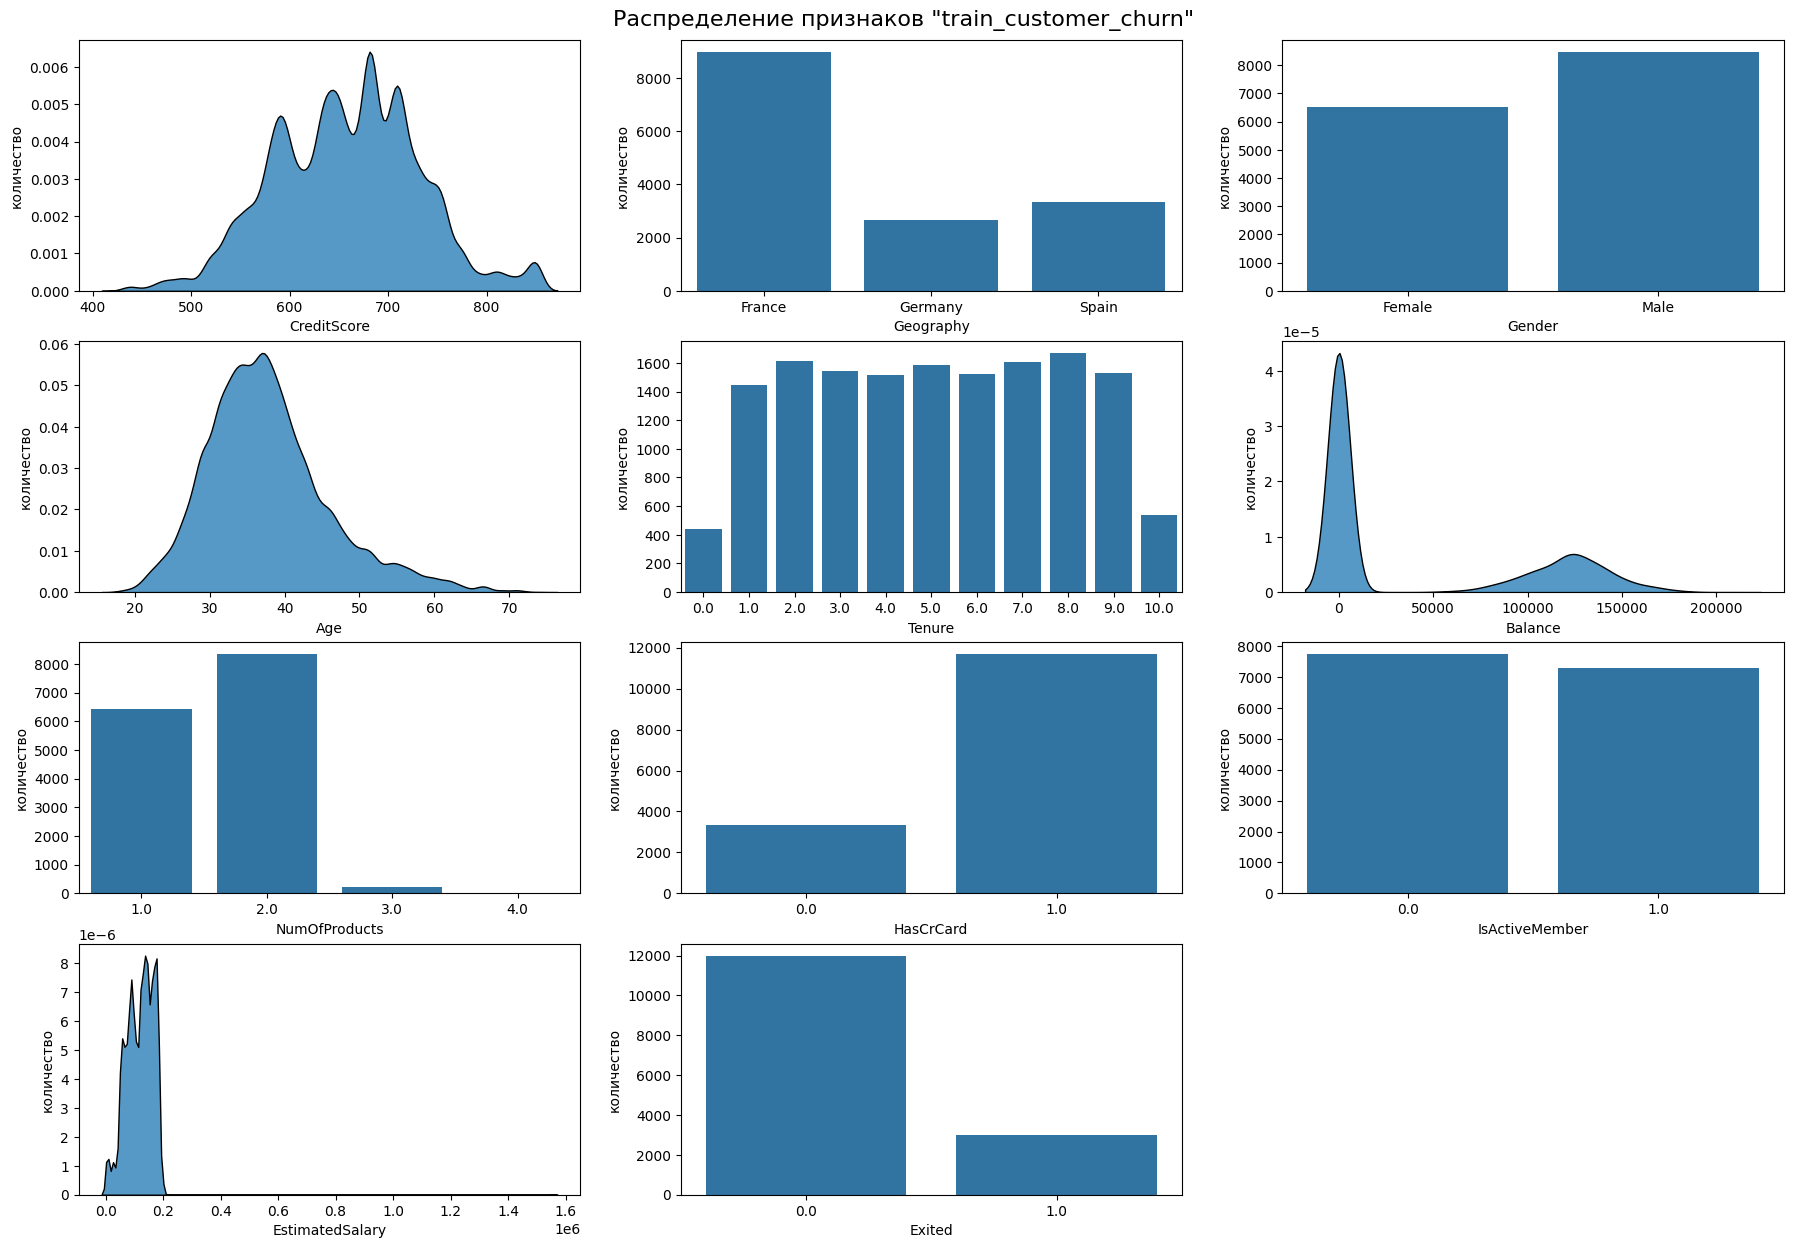

In [180]:
plt_hist(train_customer_churn)
plt.suptitle('Распределение признаков "train_customer_churn"', fontsize=16,y=0.9)
plt.show()

Чаще всего страной проживания клиента является Франция. \
Мужчины составляют незначительное большинство среди клиентов банка - 57%. \
Средний возраст клиентов банка - 37 лет. Основная клиентская база 32-42 года, тогда как младшие и старшие возрастные группы представлены незначительно. \
Клиенты с длительностью обслуживания 1-9 лет распределены равномерно. При этом новые (до года) и десятилетние клиенты встречаются реже. \
Баланс пользователей распределен бимодально. В большей степени клиенты не хранят денежные средства на счетах. \
Очень редко клиенты имеют более двух банковских продуктов. \
78% клиентов имеют кредитную карту. Активные и неактивные клиенты представлены примерно в равной пропорции. \
Признак с заработной платой имеет большой выброс. \
Целевой признак имеет явный дисбаланс классов.

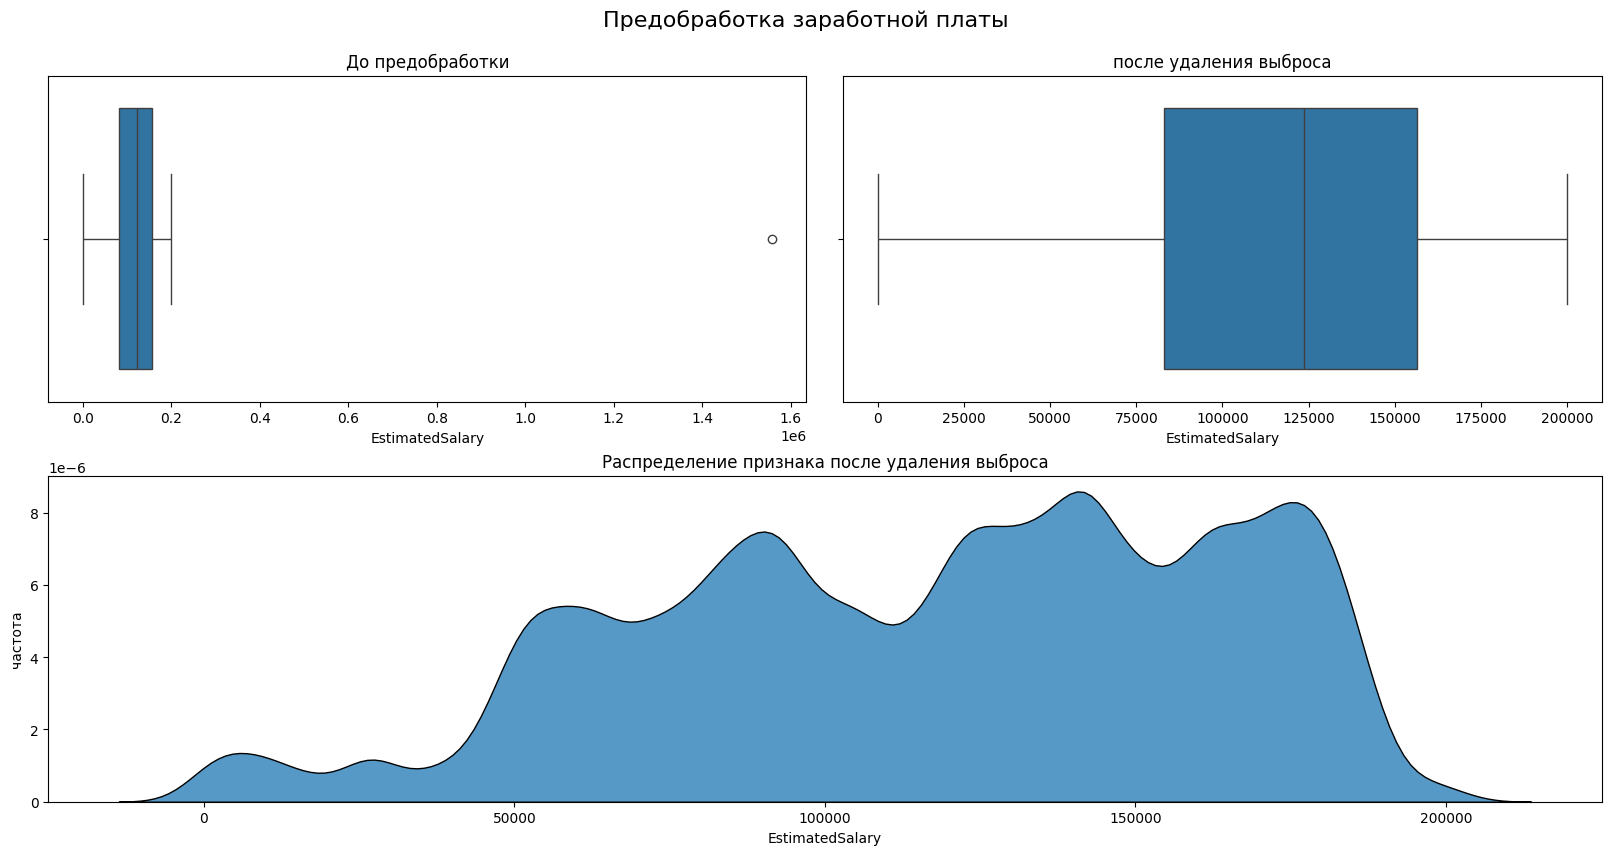

In [202]:
fg = plt.figure(figsize=(16, 8), constrained_layout=True)
gs = fg.add_gridspec(2, 2)
plt.suptitle('Предобработка заработной платы', fontsize=16, y=1.05)

fig_ax_1 = fg.add_subplot(gs[0, 0])
plt.title('До предобработки')
sns.boxplot(train_customer_churn['EstimatedSalary'], orient='h')

train_customer_churn.query('EstimatedSalary < 1.5e6', inplace=True)
train_customer_churn.reset_index(drop=True, inplace=True)

fig_ax_2 = fg.add_subplot(gs[0, 1])
plt.title('после удаления выброса')
sns.boxplot(train_customer_churn['EstimatedSalary'], orient='h')

fig_ax_3 = fg.add_subplot(gs[1, :])
plt.title('Распределение признака после удаления выброса')
sns.kdeplot(data=train_customer_churn, x='EstimatedSalary', multiple="stack", bw_method=0.1)
plt.ylabel('частота')

plt.show()

Выброс заработной платы, равный 1557651, был удален фильтром. Некоторые сотрудники имеют заработную плату близкую к 0.

#### Портрет ушедшего клиента

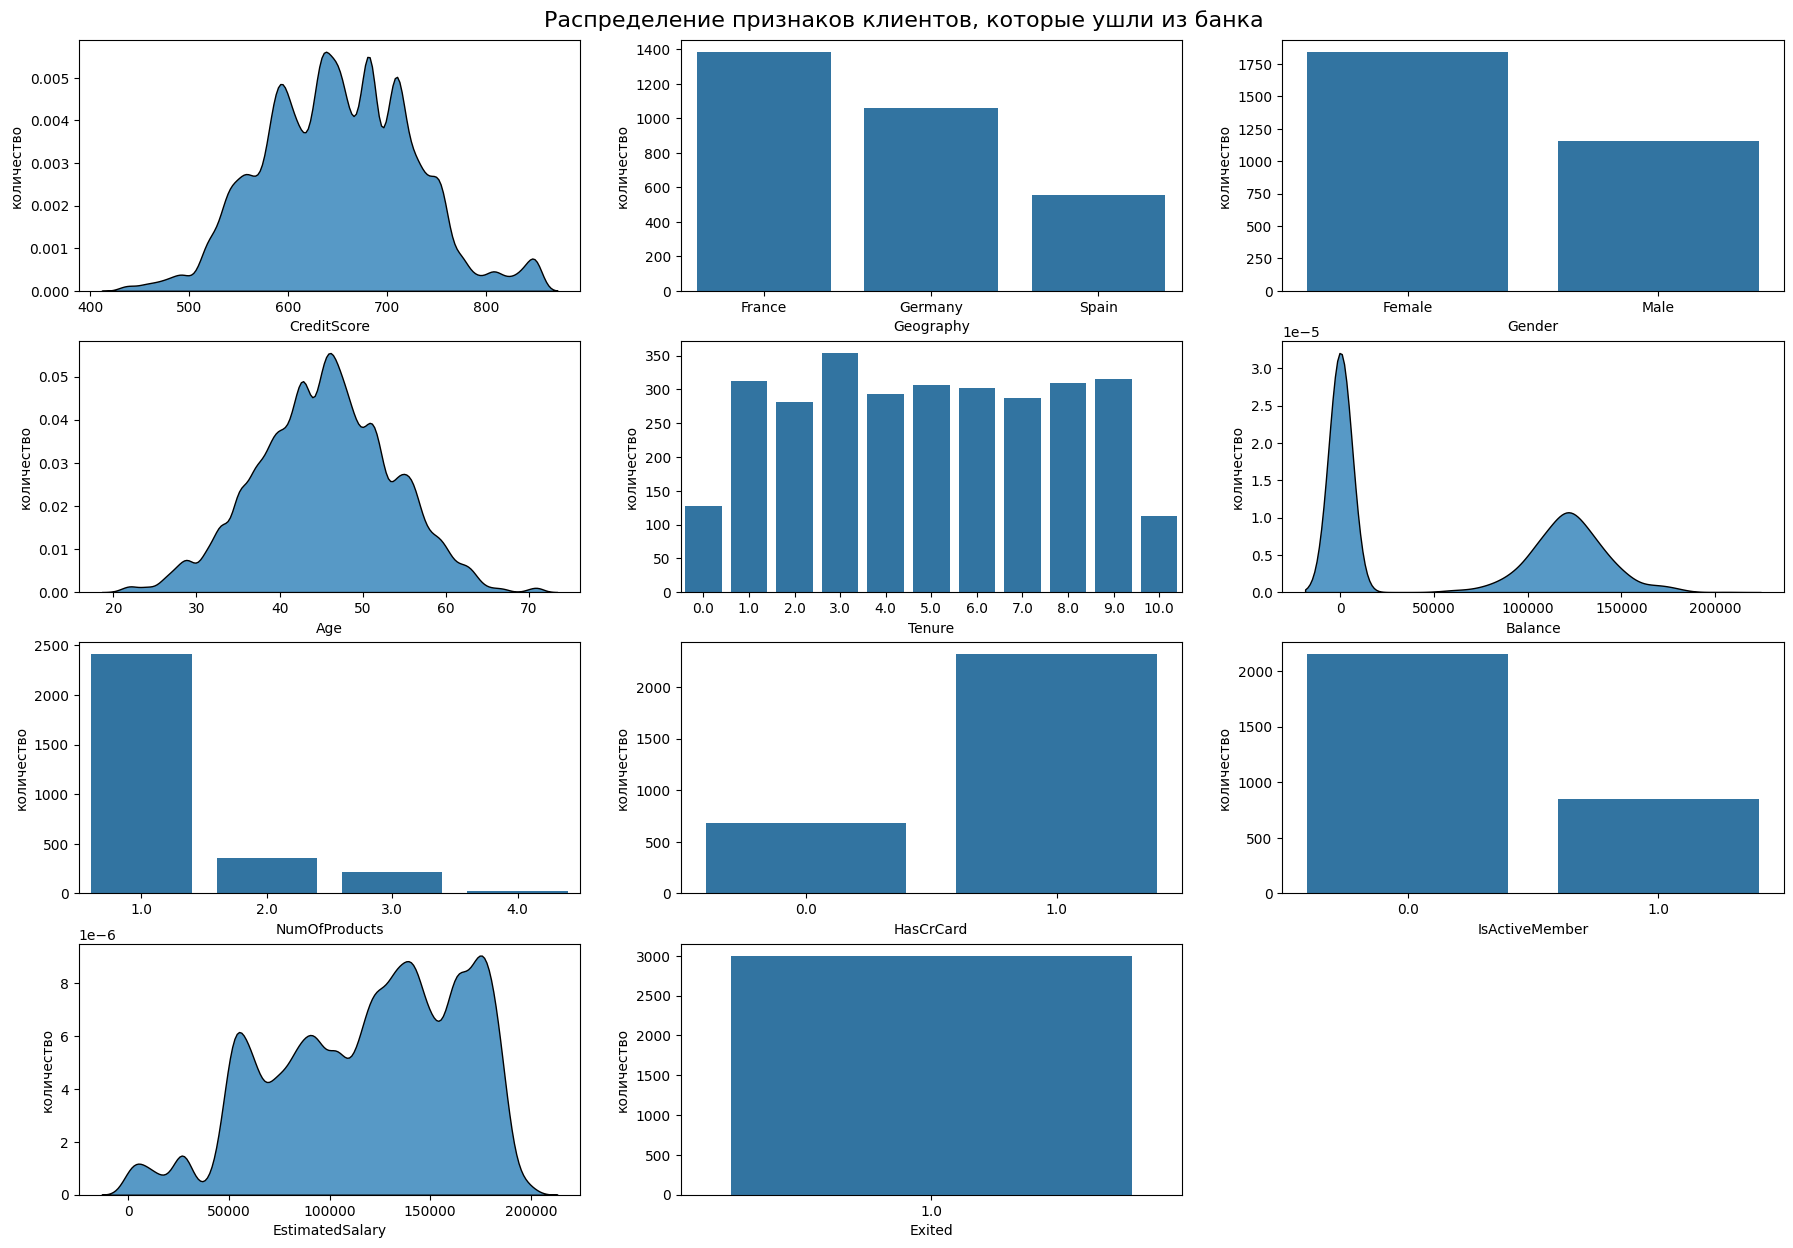

In [182]:
plt_hist(train_customer_churn.query('Exited == 1'))
plt.suptitle('Распределение признаков клиентов, которые ушли из банка', fontsize=16,y=0.9)
plt.show()

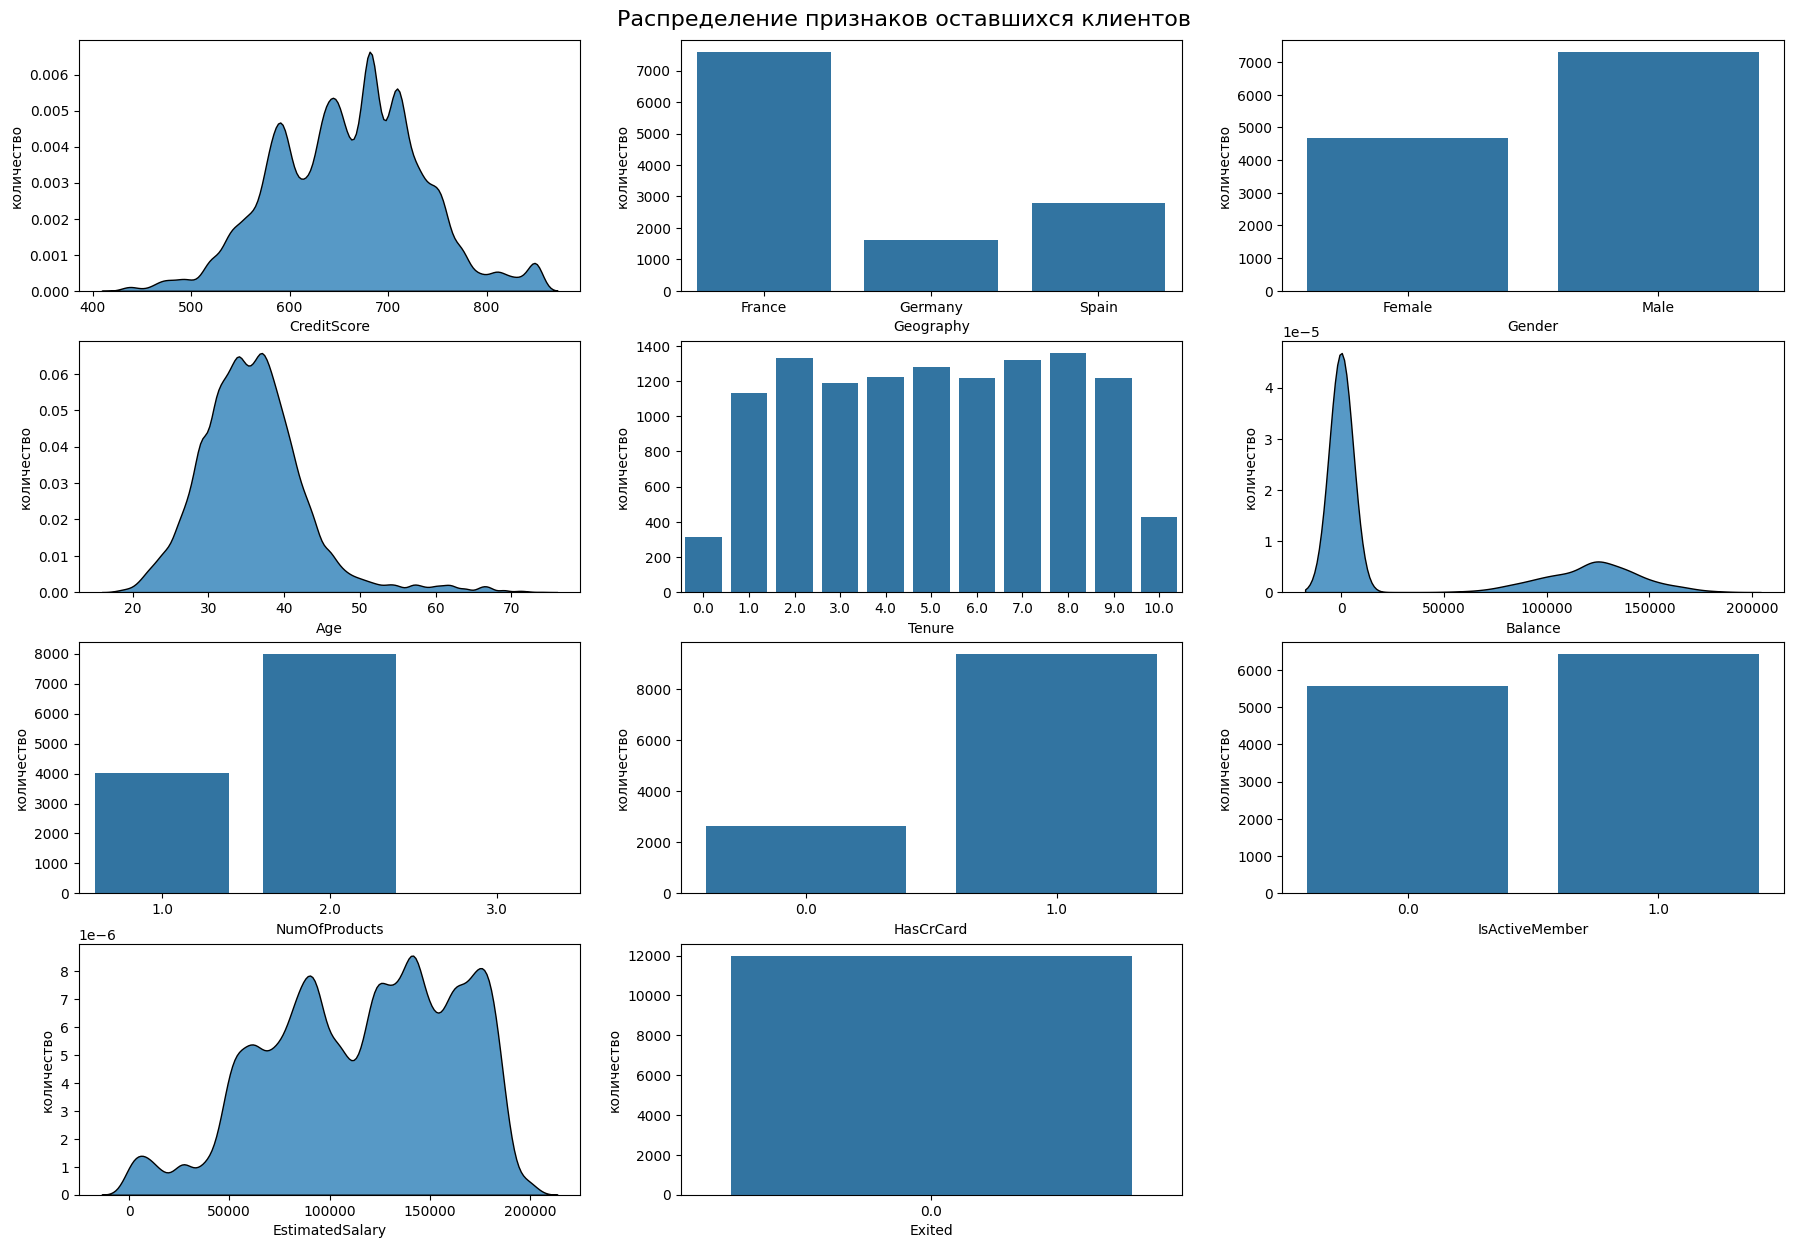

In [183]:
plt_hist(train_customer_churn.query('Exited != 1'))
plt.suptitle('Распределение признаков оставшихся клиентов', fontsize=16,y=0.9)
plt.show()

Из банка ушло 40% клиентов из Германии, 15% - из Франции и 17% - из Испании. \
Среди женщин наблюдается большая утечка клиентов - 61%, с учетом, что класс является минорным. \
Средний возраст ушедших клиентов - 45 лет, у оставшихся - 35 лет. \
Большая часть клиентов, имевших более двух банковских продуктов, покинула банк. \
Среди ушедших, не активными пользователями были 72%.

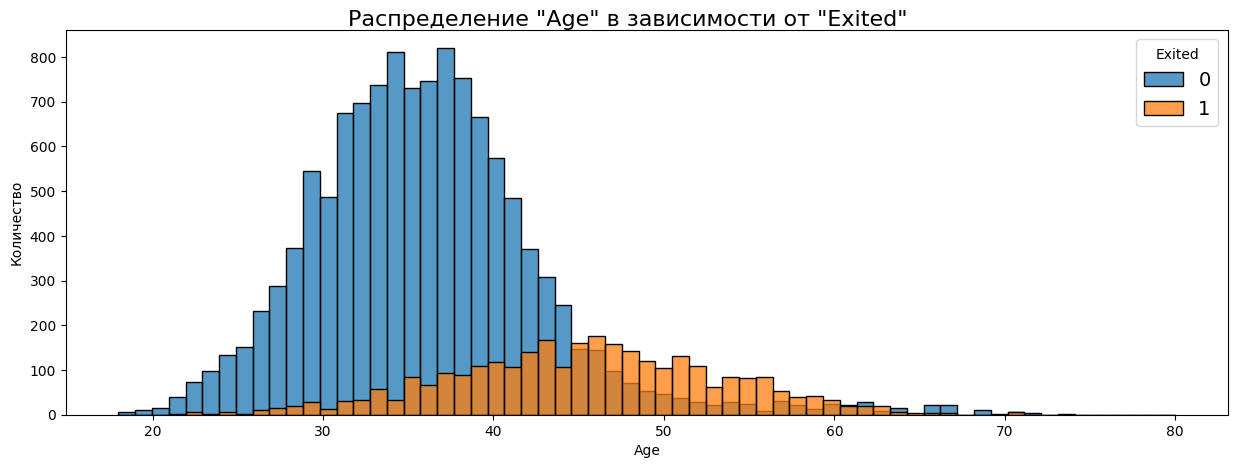

In [184]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
plt.suptitle('Распределение "Age" в зависимости от "Exited"', fontsize=16, y=0.92)

sns.histplot(data=train_customer_churn.query('Exited == 0'),
             x='Age',
             ax=ax,
             label='0',
             bins=np.linspace(18, 80, 64))
sns.histplot(data=train_customer_churn.query('Exited == 1'),
             x='Age',
             ax=ax,
             label='1',
             bins=np.linspace(18, 80, 64))
plt.ylabel('Количество')
plt.legend(title='Exited', fontsize=14)
plt.show()

Имеется высокая вероятность, что клиенты до 40 лет останутся в банке. 50-60 летние чаще оказываются в утечке. Предпологаемый сегмент для перевода в категориальный признак: менее 30 - 'молодые', от 30 до 45 - 'средние', от 45 до 60 - 'взлослые', более 60 - 'старшие'.

#### Какие клиенты не хранят деньги на счету в банке?

In [185]:
print('Количество клиентов, не имеющих денег на балансе:', train_customer_churn.query('Balance == 0').shape[0])

Количество клиентов, не имеющих денег на балансе: 9739


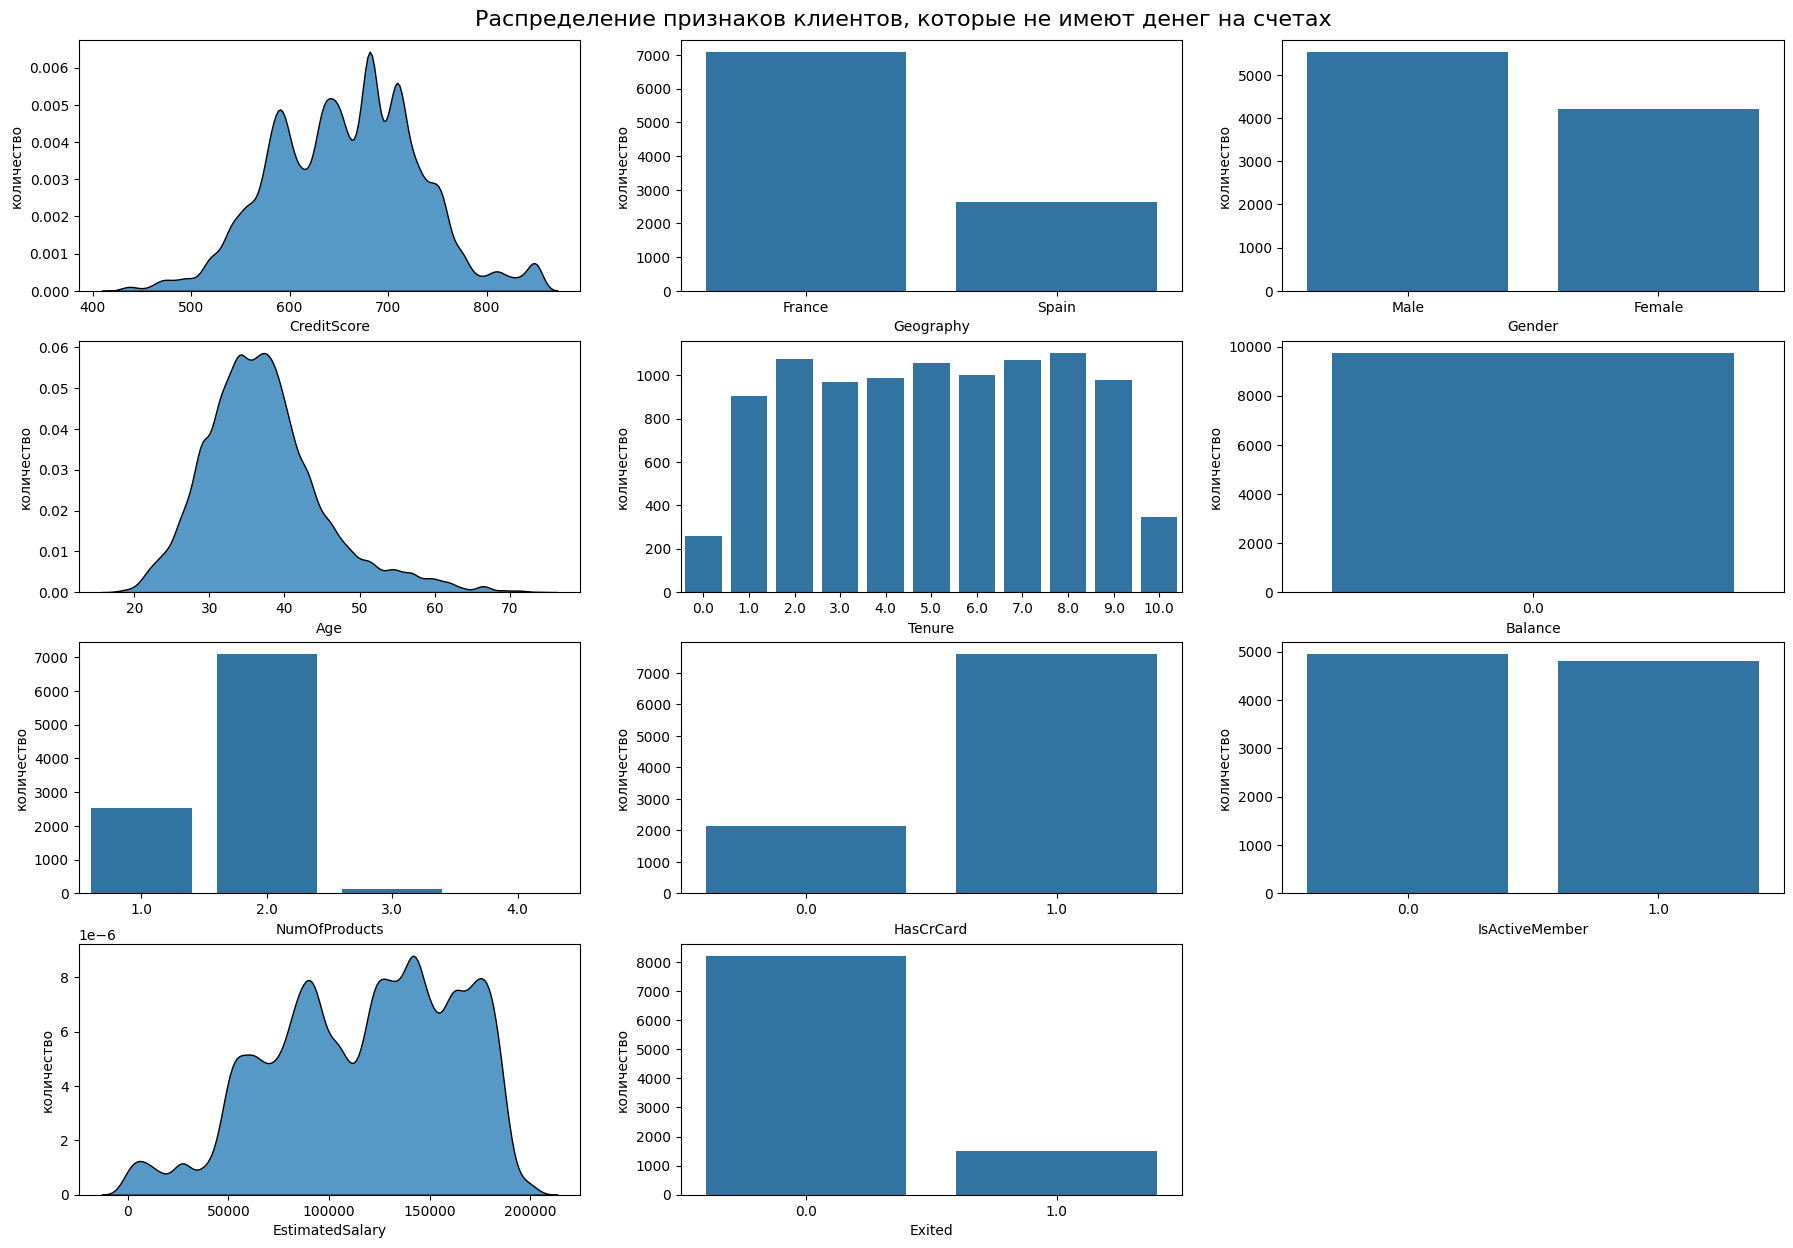

In [186]:
plt_hist(train_customer_churn.query('Balance == 0'))
plt.suptitle('Распределение признаков клиентов, которые не имеют денег на счетах', fontsize=16,y=0.9)
plt.show()

79% клиентов из Франции и 79% клиентов из Испании не хранят деньги на счетах в банке. Все клиенты из Германии имеют баланс на счету. \
Количественный признак, отвечающий за баланс клиентов на счету, является кандидатом на перевод в бинарный категориальный. Необходимо проверить, повлияет ли изменение на качество модели.

#### Аномалии и выбросы количественных признаков

In [187]:
# Функция для отображения количественных признаков
def plt_boxplot_scaler(df):
    plt.figure(figsize=(12, 6))
    scaled = MinMaxScaler()
    
    num_columns = [clm for clm in df.select_dtypes(include='number').columns.tolist() if df[clm].nunique() >= 20]
    sns.boxplot(data=pd.DataFrame(data=scaled.fit_transform(df[num_columns]), columns=num_columns), orient='v')

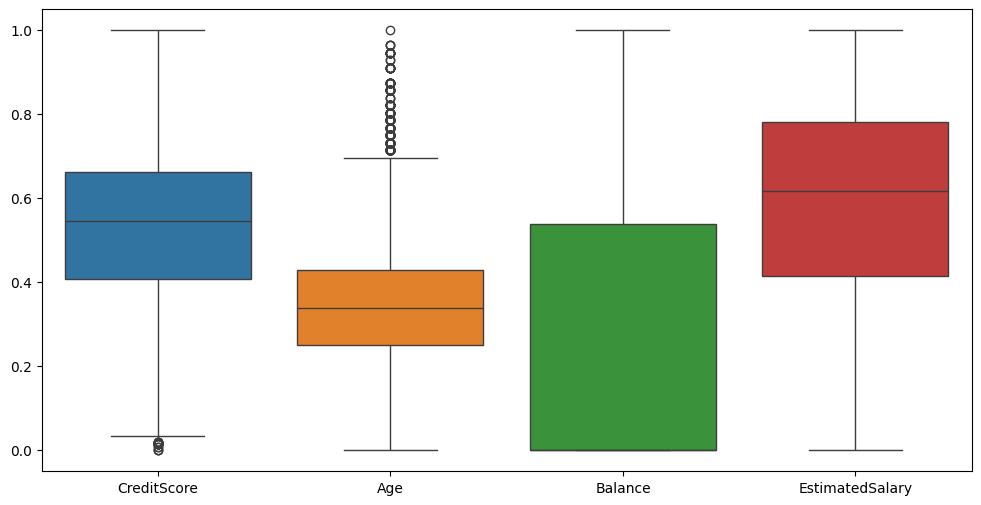

In [188]:
plt_boxplot_scaler(train_customer_churn.iloc[:, 1:])


В связи с малой долей взрослых клиентов банка, признак `Age` имеет значения-выбросы. Нет необходимости в удалении таких выбросов, можно выполнить возрастную сегментацию, поделив возраст на категории.

#### Корреляционный анализ

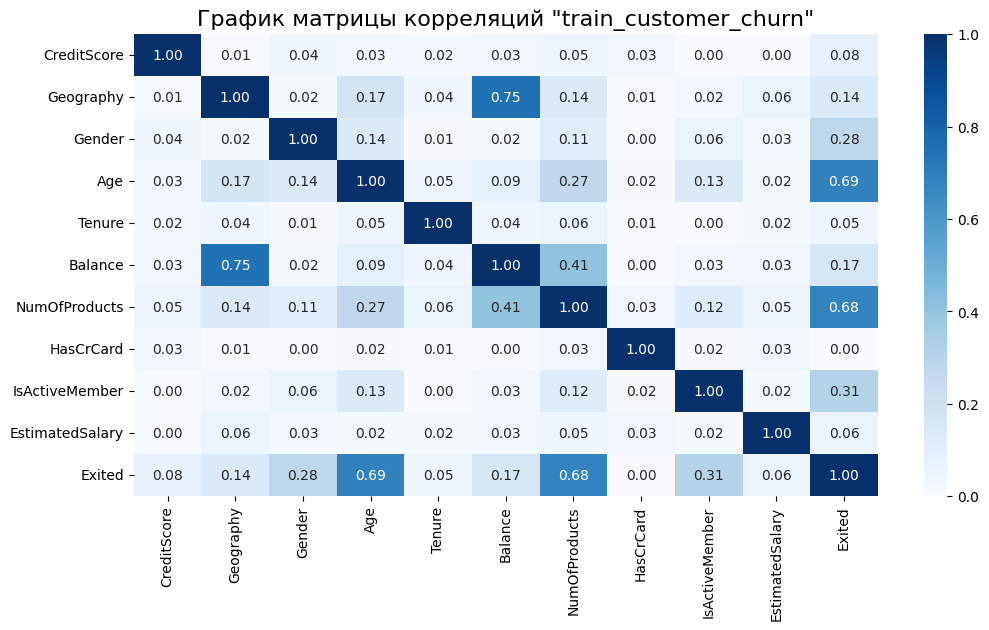

In [ ]:
plt.figure(figsize=(12, 6))

plt.title('График матрицы корреляций "train_customer_churn"', fontsize=16)
sns.heatmap(train_customer_churn.iloc[:, 2:].phik_matrix(interval_cols=['CreditScore', 'Age', 'Balance', 'EstimatedSalary']),
            annot=True,
            fmt='.2f',
            cmap='Blues')

plt.show()

Для матрицы корреляций была использована матрица phik, она анализирует корреляцию между признаками любого типа и не требует предварительного кодирования. Матрицы корреляций Пирсона/Спирмена не может быть оценена вообще (в случае категориальных) или не может быть оценена корректно (в случае дискретных).

1. Мультиколлинеарность:
    - Высокая у `Geography` и `Balance` - 0.75
    - Слабая у `Balance` и `NumOfProducts` - 0.68

2. Связь с целевым:
    - `Age` - 0.69
    - `NumOfProducts` - 0.68

#### Вывод исследовательского анализа

Чаще всего страной проживания клиента является Франция, из которой ушло 15% пользователей, из Испании - 17%, из Германии - 40%. Средний возраст клиентов банка - 37 лет, средний возраст ушедших клиентов - 45 лет, у оставшихся - 35 лет. Основная клиентская база: 32-42 года. Всего 9739 клиентов, не хранящих деньги на счетах, из них большая часть из Испании и Франции, зато абсолютно все клиенты из Германии имеют баланс на счету. Большая часть клиентов, имевших более двух банковских продуктов, покинула банк. Среди ушедших, не активными пользователями были 72%. Целевой признак имеет явный дисбаланс классов.

`Balance` является кандидатом на перевод в бинарный категориальный. Также данный признак имеет мультиколлинеарность с двумя входными признаками. \
`Age` тоже может быть переведен в категориальный по возрастным группам, имеет высокую связь с целевым.

### [Подготовка данных и обучение моделей](#task_4_plan) <a id='task_4'></a>

#### Первая итерация

##### Подготовка данных

In [ ]:
X = train_customer_churn.drop(['CustomerId', 'Surname', 'Exited'], axis=1)
y = train_customer_churn['Exited']

Отобраны входные признаки, они не включают id пользователя, его имя и целевой признак.

In [ ]:
ohe_cols = ['Geography', 'Gender']
scaled_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

Признак `Geography` и `Gender` будут кодироваться OneHotEncoder в связи с тем, что они не является ранговыми переменнами. Количественные признаки будут отмасштабированы, используя MinMaxScaler.

In [ ]:
pipe_ohe = Pipeline([
    ('simple_imputer_before',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe',
     OneHotEncoder(drop='first',sparse_output=False ,handle_unknown='ignore')) # избегаем дамми-ловушку (drop='first')
])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_cols),
        ('scaled', MinMaxScaler(), scaled_cols)
    ],
    remainder='passthrough'
)

pipe = Pipeline([
    ('preprocessing', data_preprocessor),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

Создан пайплайн для подготовки данных и обучения моделей.

##### Обучение моделей

In [ ]:
param_grid= [
    {'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
     'models__max_depth': range(3, 15),
     'models__max_features': range(2, 5),
     'models__min_samples_split': range(2,7)},
    
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': range(10, 50)},

    {'models': [LogisticRegression(random_state=RANDOM_STATE)],
     'models__penalty': ['l1', 'l2', 'elasticnet', None],
     'models__C': range(1, 10)}]

In [ ]:
grid_cv = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring={'roc_auc_score': 'roc_auc',
             'f1_score': 'f1'},
    refit='roc_auc_score',
    n_jobs=-1
)

grid_cv.fit(X, y)

/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simple_imputer_before',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Geography',
                                                                          'Gender']),
                                                                        ('scaled',
                                                                         MinMaxScaler(),
                                                                         ['CreditScore...
                          'models__max_depth': range(3, 15),
                          'models__max_features': range(2, 5),
                          'models__min_samples_split': range(2, 7)},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(10, 50)},
                         {'models': [LogisticRegression(random_state=42)],
                          'models__C': range(1, 10),
                          'models__penalty': ['l1', 'l2', 'elasticnet', None]}],
             refit='roc_auc_score',
             scoring={'f1_score': 'f1', 'roc_auc_score': 'roc_auc'})

In [ ]:
res_pipe = pd.DataFrame(grid_cv.cv_results_).sort_values('mean_test_roc_auc_score', ascending=False).drop('params', axis=1)
res_pipe[~res_pipe.duplicated(subset=['param_models'])]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_models__min_samples_split,param_models__n_neighbors,param_models__C,param_models__penalty,split0_test_roc_auc_score,split1_test_roc_auc_score,split2_test_roc_auc_score,split3_test_roc_auc_score,split4_test_roc_auc_score,mean_test_roc_auc_score,std_test_roc_auc_score,rank_test_roc_auc_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score
192,0.022858,0.000577,0.384072,0.014581,KNeighborsClassifier(),NaN,NaN,NaN,22,NaN,NaN,0.892093,0.889085,0.898558,0.910394,0.910241,0.900074,0.008906,1,0.617706,0.600203,0.634615,0.632911,0.645226,0.626133,0.015658,116
88,0.026681,0.002446,0.019364,0.002303,DecisionTreeClassifier(random_state=42),8,4,5,NaN,NaN,NaN,0.865849,0.885239,0.888194,0.902969,0.895971,0.887644,0.012532,41,0.649007,0.692377,0.694367,0.704681,0.680038,0.684094,0.019212,1
251,0.025550,0.002782,0.018761,0.002307,LogisticRegression(random_state=42),NaN,NaN,NaN,NaN,8,None,0.866841,0.874230,0.877409,0.885193,0.889556,0.878646,0.008028,55,0.595025,0.609901,0.632984,0.639546,0.667310,0.628953,0.024955,95


Лучшая модель среди отобранных по сетке - KNeighborsClassifier 
- ROC-AUC: 0.90
- f1-score: 0.626
- гиперпараметры: n_neighbors=22

Низкая f1-мера связана с дисбалансом классов. У модели есть трудности с минорным классом.

In [ ]:
# функция для прогресс-бара
def tqdm_callback_clf(study, trial, pbar):
    pbar.update(1)
    if study.best_trial.number == trial.number:
        pbar.set_postfix({"Лучшая метрика ROC-AUC": f"{trial.value:.4f}"})


# Функция для поиска наилучших гиперпараметров, используя Байесовскую оптимизацию
def optuna_search_clf(param_distributions, X, y, pipe, epoch=20):
    pbar = tqdm(total=epoch, desc="Поиск гиперпараметров Optuna")

    oscv = OptunaSearchCV(
        pipe,
        param_distributions,
        scoring='roc_auc',
        cv=3,
        n_trials=epoch,
        random_state=RANDOM_STATE,
        callbacks=[partial(tqdm_callback_clf, pbar=pbar)]
    )

    oscv.fit(X, y)
    pbar.close()
    
    return oscv

In [ ]:
param_distributions_svc = {
    "models": CategoricalDistribution([
        SVC(random_state=RANDOM_STATE, probability=True)]),
    
    "models__kernel": CategoricalDistribution(['rbf', 'sigmoid', 'poly']),
    "models__C": IntDistribution(1, 10),
    "models__degree": IntDistribution(1, 5)
}


oscv_svc = optuna_search_clf(param_distributions_svc, X, y, pipe)

Поиск гиперпараметров Optuna:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-14 15:22:28,224] A new study created in memory with name: no-name-aee6103c-5871-48e3-b1fb-bde5796edc6b
[I 2025-05-14 15:22:43,289] Trial 0 finished with value: 0.7557576593615604 and parameters: {'models': SVC(C=4, kernel='sigmoid', probability=True, random_state=42), 'models__kernel': 'sigmoid', 'models__C': 4, 'models__degree': 3}. Best is trial 0 with value: 0.7557576593615604.
[I 2025-05-14 15:22:52,883] Trial 1 finished with value: 0.9033104758040992 and parameters: {'models': SVC(C=2, degree=2, probability=True, random_state=42), 'models__kernel': 'rbf', 'models__C': 2, 'models__degree': 2}. Best is trial 1 with value: 0.9033104758040992.
[I 2025-05-14 15:23:07,923] Trial 2 finished with value: 0.7558936903723102 and parameters: {'models': SVC(C=3, degree=2, kernel='sigmoid', probability=True, random_state=42), 'models__kernel': 'sigmoid', 'models__C': 3, 'models__degree': 2}. Best is trial 1 with value: 0.9033104758040992.
[I 2025-05-14 15:23:33,055] Trial 3 finished 

In [ ]:
param_distributions_gbc = {
    "models": CategoricalDistribution([
        GradientBoostingClassifier(random_state=RANDOM_STATE)]),
    
    "models__n_estimators": IntDistribution(50, 500),
    "models__learning_rate": FloatDistribution(0.01, 0.2, log=True),
    "models__max_depth": IntDistribution(3, 10),
    "models__min_samples_split": IntDistribution(2, 20),
    "models__min_samples_leaf": IntDistribution(1, 10),
    "models__subsample": FloatDistribution(0.5, 1.0),
    "models__max_features": CategoricalDistribution(["sqrt", "log2", None])
}

oscv_gbc = optuna_search_clf(param_distributions_gbc, X, y, pipe, epoch=35)

Поиск гиперпараметров Optuna:   0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-05-15 13:33:15,907] A new study created in memory with name: no-name-587de729-52ea-4ee4-9903-54952bcc649d
[I 2025-05-15 13:33:17,831] Trial 0 finished with value: 0.9351027032482397 and parameters: {'models': GradientBoostingClassifier(learning_rate=0.12113767929988348,
                           max_features='sqrt', min_samples_leaf=5,
                           min_samples_split=8, n_estimators=255,
                           random_state=42, subsample=0.6491308156825654), 'models__n_estimators': 255, 'models__learning_rate': 0.12113767929988348, 'models__max_depth': 3, 'models__min_samples_split': 8, 'models__min_samples_leaf': 5, 'models__subsample': 0.6491308156825654, 'models__max_features': 'sqrt'}. Best is trial 0 with value: 0.9351027032482397.
[I 2025-05-15 13:33:28,679] Trial 1 finished with value: 0.9297793638386286 and parameters: {'models': GradientBoostingClassifier(learning_rate=0.02845427341868521, max_depth=10,
                           min_samples_leaf=3, mi

Модели и их лучшая метрика ROC-AUC на подобранных гипермараметрах 

- **GBC**: 0.936
- **SVC**: 0.908
- **KNeighborsClassifier**: 0.9
- **DecisionTreeClassifier**: 0.887
- **LogisticRegression**: 0.878

Лучше всех справилась модель **GradientBoostingClassifier** \
Гиперпараметры лучшей модели:
- learning_rate=0.0389
- max_depth=5
- min_samples_leaf=3
- min_samples_split=10
- n_estimators=216
- subsample=0.768

##### Анализ важности признаков

In [ ]:
# Функция для анализа важности признаков
def get_shape_beeswarm(oscv, X, size=100):
    model = oscv.best_estimator_.named_steps['models']
    preprocessor = oscv.best_estimator_.named_steps['preprocessing']
    name_model = oscv.best_estimator_.named_steps['models'].__class__.__name__

    X_train_scaled = pd.DataFrame(data=preprocessor.transform(X), columns=preprocessor.get_feature_names_out())


    n_samples = X_train_scaled.shape[0]
    np.random.seed(42)
    random_indices = np.random.choice(n_samples, size=size, replace=False)

    explainer = shap.Explainer(model.predict, X_train_scaled.iloc[random_indices, :])
    shap_values = explainer(X_train_scaled.iloc[random_indices, :])

    shap.plots.beeswarm(shap_values, show=False) 
    # Настройка отображения осей
    fig, ax = plt.gcf(), plt.gca()

    ax.tick_params(labelsize=14)
    ax.set_title(f'Вклад признаков в каждое предсказание модели {name_model}', fontsize=16, y=1.05)
    ax.set_xlabel("влияние на выходные данные модели\nSHAP-значение", fontsize=14)
    ax.set_ylabel('входные признаки')

    cb_ax = fig.axes[1] 
    cb_ax.tick_params(labelsize=15)
    cb_ax.set_ylabel("значение признаков", fontsize=20)

    plt.show()

PermutationExplainer explainer: 501it [11:12,  1.36s/it]                         


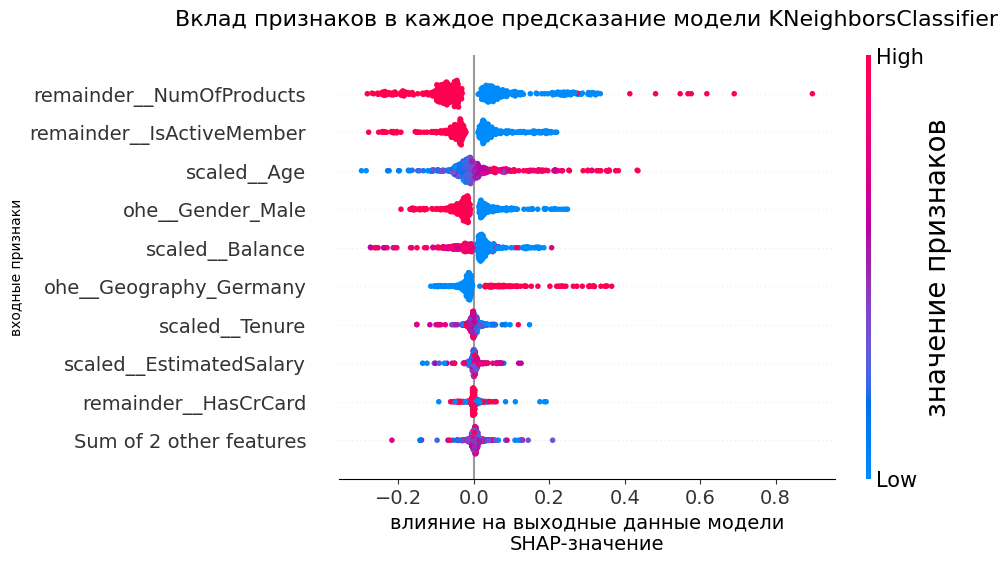

In [ ]:
get_shape_beeswarm(grid_cv, X, size=500)

**Влияние признаков на предсказательскую способность модели KNeighborsClassifier**

1. Большие значения склоняют к классу 1:
    - `Age`
    - `Geography_Germany`

2. Большие значения склоняют к классу 0:
    - `NumOfProducts`
    - `IsActiveMember`
    - `Gender_male`
    - `Balance`

3. Не имеющие особого влияния:
    - `EstimatedSalary`
    - `HasCrCard`
    - `CreditScore`
    - `Geography_Spain`

PermutationExplainer explainer: 501it [12:10,  1.48s/it]                         


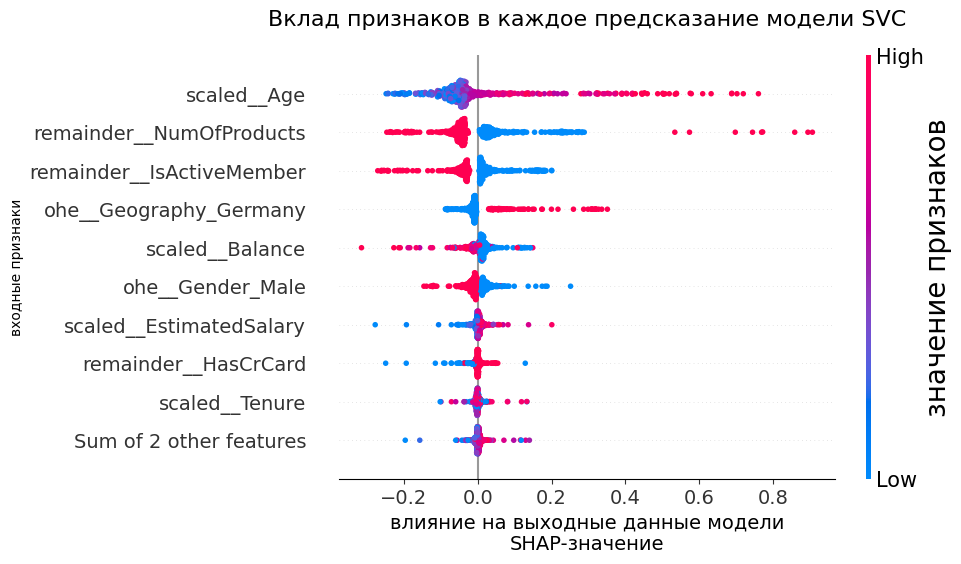

In [ ]:
get_shape_beeswarm(oscv_svc, X, size=500)

**Влияние признаков на предсказательскую способность модели SVC**

1. Большие значения склоняют к классу 1:
    - `Age`
    - `Geography_Germany`
    - `EstimatedSalary`
    - `HasCrCard`

2. Большие значения склоняют к классу 0:
    - `NumOfProducts`
    - `IsActiveMember`
    - `Balance`
    - `Gender_male`

3. Не имеющие особого влияния:
    - `Tenure`
    - `CreditScore`
    - `Geography_Spain`

PermutationExplainer explainer: 501it [01:00,  6.85it/s]                         


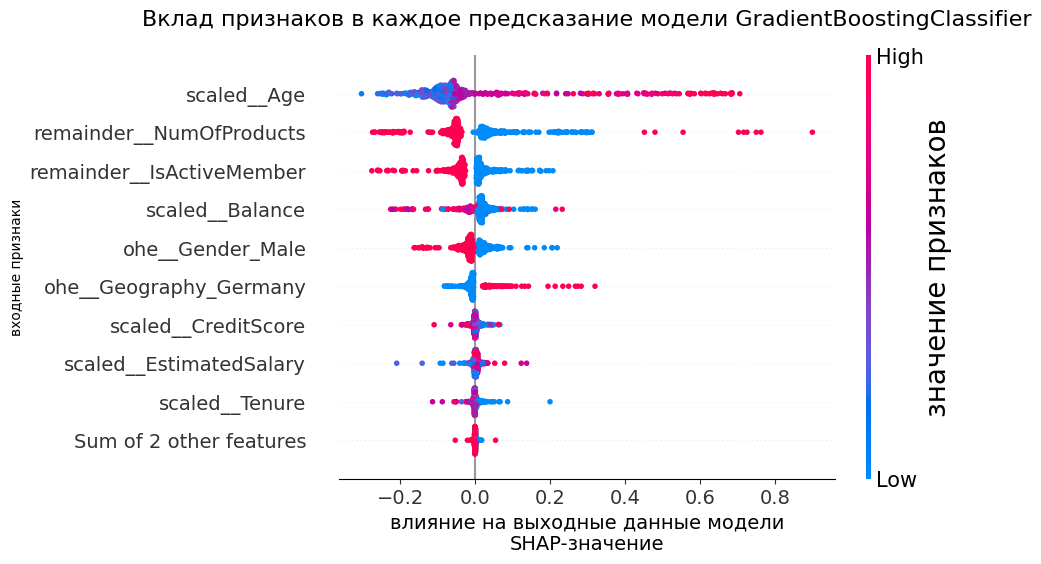

In [ ]:
get_shape_beeswarm(oscv_gbc, X, size=500)

**Влияние признаков на предсказательскую способность модели GradientBoostingClassifier**

1. Большие значения склоняют к классу 1:
    - `Age`
    - `Geography_Germany`

2. Большие значения склоняют к классу 0:
    - `NumOfProducts`
    - `IsActiveMember`
    - `Gender_male`
    - `Balance`

3. Не имеющие особого влияния:
    - `CreditScore`
    - `EstimatedSalary`
    - `Geography_Spain`
    - `HasCrCard`


Все три лучшие модели имеют незначимые признаки: `Geography_Spain`, `CreditScore`. Следовательно, их можно удалить из входных признаков, это облегчит сложность моделей.

#### Вторая итерация

##### Добавление данных

In [ ]:
path0 = './datasets/Churn_Modelling.csv'
path1 = kagglehub.dataset_download("shubhammeshram579/bank-customer-churn-prediction") # директория для kagle 

churn_new = check_dataset(path0, path1, sep=',')

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


,пропуски_%
Geography,0.009998
Age,0.009998
HasCrCard,0.009998
IsActiveMember,0.009998
CustomerId,0.000000
RowNumber,0.000000
Gender,0.000000
CreditScore,0.000000
Surname,0.000000
Tenure,0.000000


В датасете наблюдаются пропуски. Пропуски с таким малым процентом стоит удалять.

In [204]:
churn_new = churn_new.dropna().reset_index(drop=True).set_index('RowNumber')
(churn_new.isna().mean() * 100).sort_values(ascending=False).to_frame(name='пропуски_%')

,пропуски_%
CustomerId,0.0
Surname,0.0
CreditScore,0.0
Geography,0.0
Gender,0.0
Age,0.0
Tenure,0.0
Balance,0.0
NumOfProducts,0.0
HasCrCard,0.0


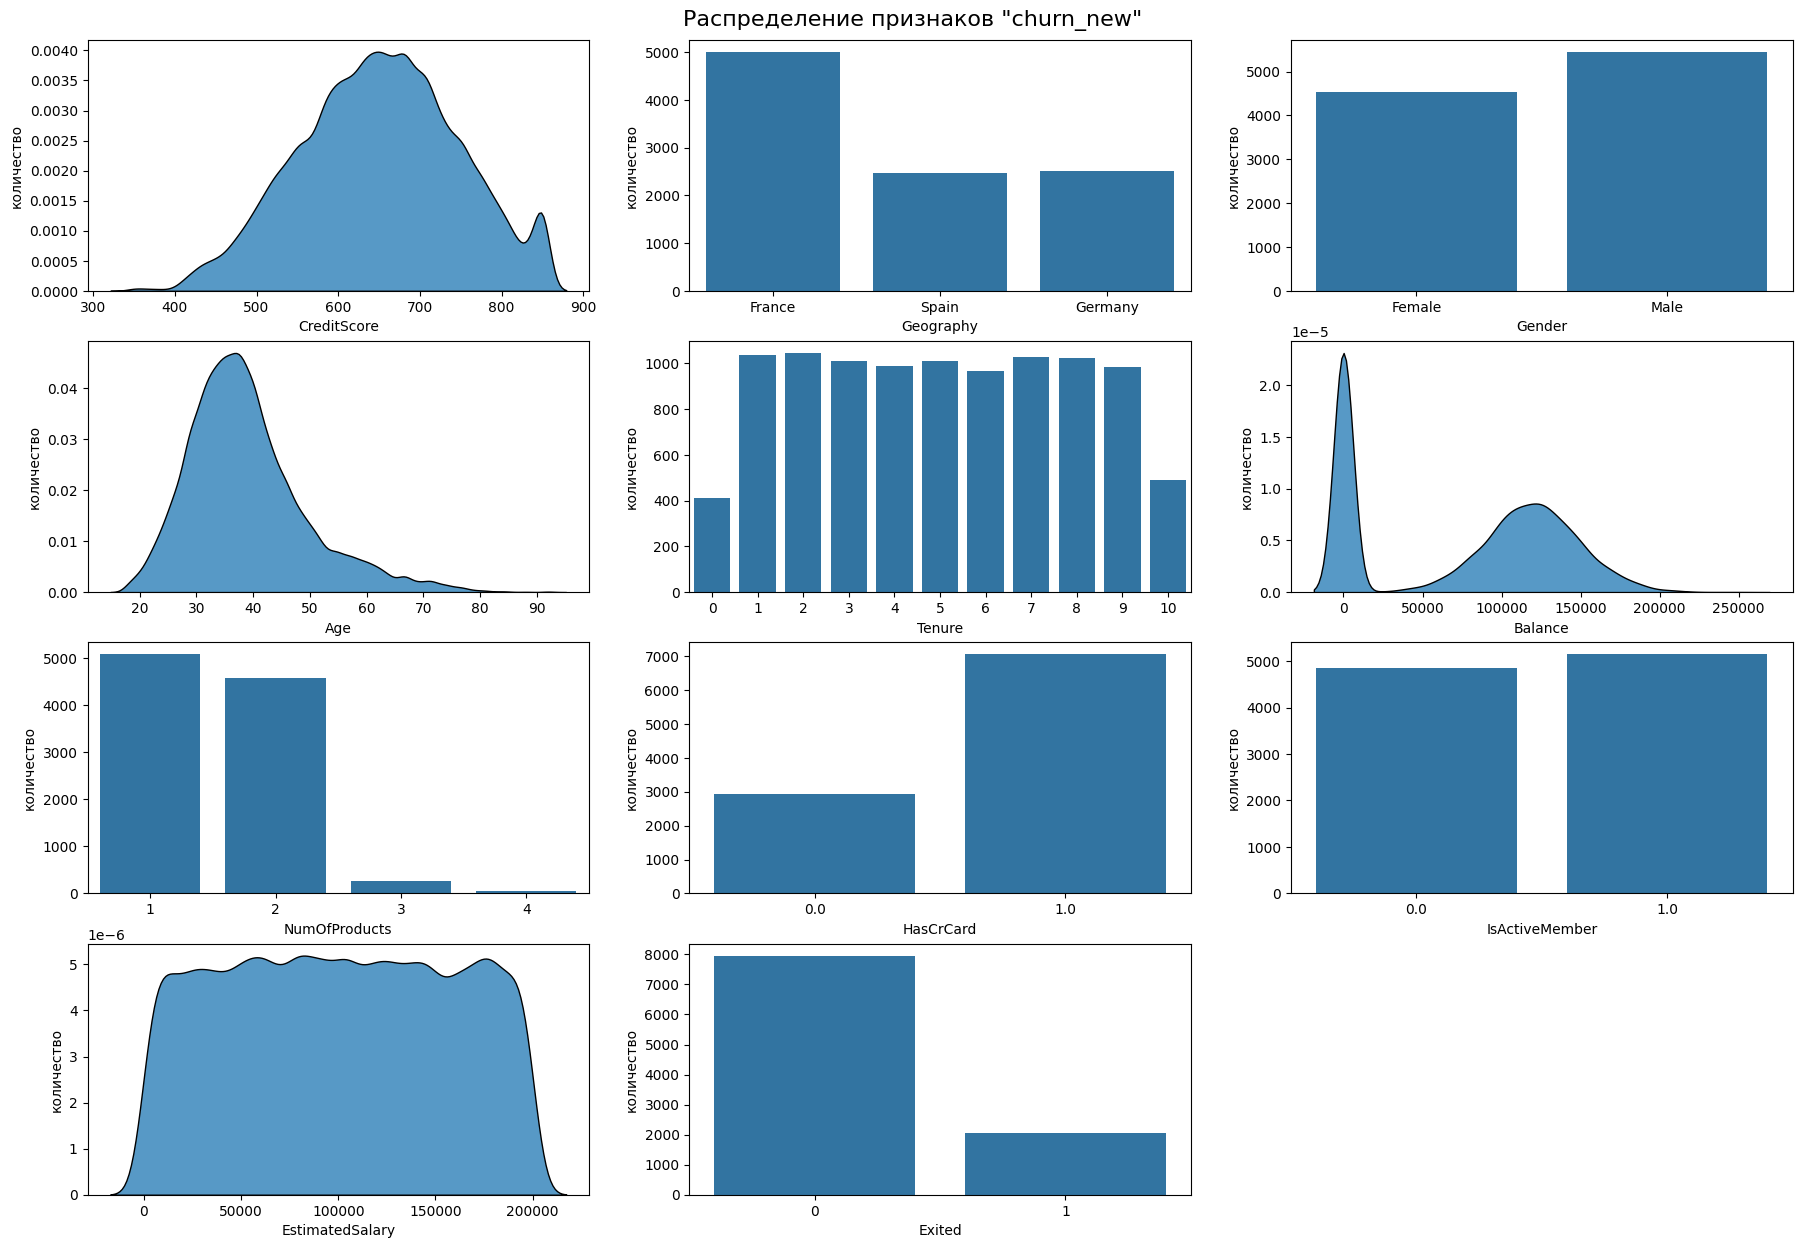

In [207]:
plt_hist(churn_new)
plt.suptitle('Распределение признаков "churn_new"', fontsize=16,y=0.9)
plt.show()

Распределение признаков нового датасета имеет схожесть с исходными наборами. Следовательно, можно добавить в тренировочный набор данные с классом **1** признака `Exited`, чтобы произвести сэмплирование и немного избавиться от дисбаланса классов.

In [210]:
churn_new.query('Exited == 1')

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
6,15574012,Chu,645,Spain,Male,44.0,8,113755.78,2,1.0,0.0,149756.71,1
8,15656148,Obinna,376,Germany,Female,29.0,4,115046.74,4,1.0,0.0,119346.88,1
17,15737452,Romeo,653,Germany,Male,58.0,1,132602.88,1,1.0,0.0,5097.67,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9983,15768163,Griffin,655,Germany,Female,46.0,7,137145.12,1,1.0,0.0,115146.40,1
9992,15769959,Ajuluchukwu,597,France,Female,53.0,4,88381.21,1,1.0,0.0,69384.71,1
9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1


In [208]:
train_customer_churn['Exited'].value_counts()

Exited
0.0    11997
1.0     3002
Name: count, dtype: int64

#### Третья итерация

##### Добавление входных признаков

In [ ]:
train_customer_churn['BalanceTrue'] = train_customer_churn['Balance'].apply(lambda x: x > 0)

Был добавлен признак `BalanceTrue` - имеется ли баланс на счету у клиента.

In [ ]:
train_customer_churn['AgeGroup'] = pd.cut(train_customer_churn['Age'],
                                          bins=[0, 30, 45, 60, np.inf],
                                          labels=['молодые', 'средние', 'взлослые', 'старшие'],
                                          right=False)

Был добавлен признак `AgeGroup` - с категориями по возрастным группам.

In [ ]:
train_customer_churn

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceTrue,AgeGroup
0,15648047.0,Macleod,554.0,France,Female,32.0,3.0,98649.55,1.0,0.0,1.0,177099.71,0.0,True,средние
1,15664681.0,Nnachetam,710.0,France,Male,38.0,9.0,0.00,2.0,0.0,0.0,141872.05,0.0,False,средние
2,15762605.0,Zikoranachidimma,603.0,France,Female,38.0,9.0,136622.42,1.0,1.0,1.0,90212.38,0.0,True,средние
3,15674750.0,Clements,710.0,France,Female,35.0,8.0,0.00,2.0,1.0,0.0,148811.81,0.0,False,средние
4,15706463.0,Pinto,678.0,France,Male,34.0,8.0,0.00,2.0,0.0,0.0,148528.24,0.0,False,средние
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,15682021.0,Bellucci,774.0,Spain,Male,35.0,3.0,0.00,2.0,1.0,0.0,115985.38,0.0,False,средние
14995,15589224.0,Yermakov,619.0,France,Male,32.0,2.0,0.00,1.0,1.0,1.0,157567.37,0.0,False,средние
14996,15668575.0,Nickson,637.0,France,Male,43.0,9.0,0.00,2.0,1.0,1.0,145567.34,0.0,False,средние
14997,15583371.0,Cattaneo,604.0,Spain,Female,47.0,0.0,0.00,2.0,1.0,0.0,155846.67,0.0,False,взлослые


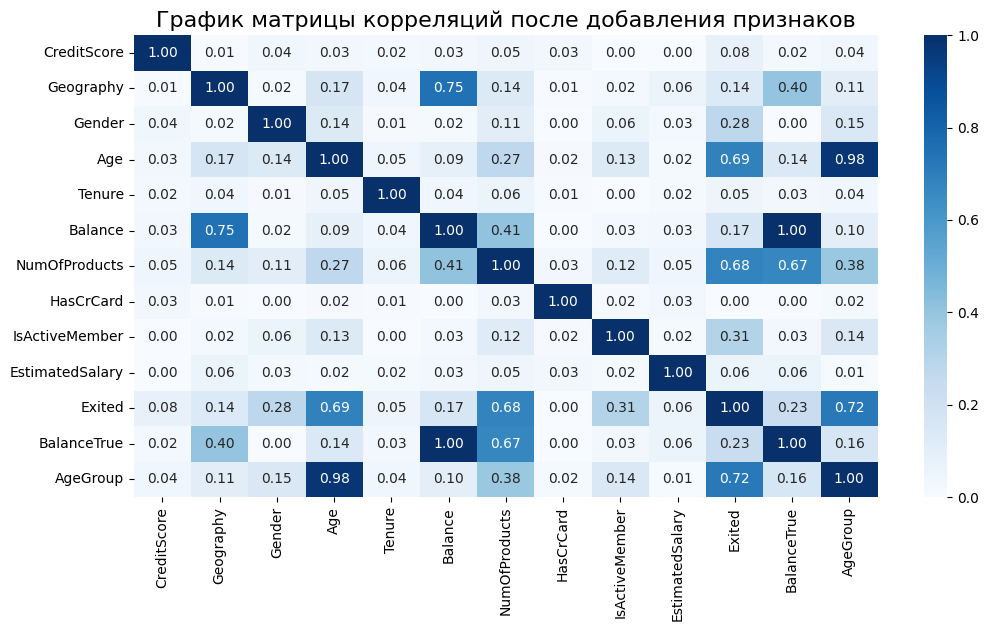

In [ ]:
plt.figure(figsize=(12, 6))

plt.title('График матрицы корреляций после добавления признаков', fontsize=16)
sns.heatmap(train_customer_churn.iloc[:, 2:].phik_matrix(interval_cols=['CreditScore', 'Age', 'Balance', 'EstimatedSalary']),
            annot=True,
            fmt='.2f',
            cmap='Blues')

plt.show()

Добавленные признаки имеют большую корреляцию с целевым, по сравнению с изначальными.

##### Подготовка данных

In [ ]:
X_iter2 = train_customer_churn.drop(['CustomerId', 'Surname', 'Exited', 'Age', 'Balance'], axis=1)
X_iter2

,CreditScore,Geography,Gender,Tenure,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,BalanceTrue,AgeGroup
0,554.0,France,Female,3.0,1.0,0.0,1.0,177099.71,True,средние
1,710.0,France,Male,9.0,2.0,0.0,0.0,141872.05,False,средние
2,603.0,France,Female,9.0,1.0,1.0,1.0,90212.38,True,средние
3,710.0,France,Female,8.0,2.0,1.0,0.0,148811.81,False,средние
4,678.0,France,Male,8.0,2.0,0.0,0.0,148528.24,False,средние
...,...,...,...,...,...,...,...,...,...,...
14994,774.0,Spain,Male,3.0,2.0,1.0,0.0,115985.38,False,средние
14995,619.0,France,Male,2.0,1.0,1.0,1.0,157567.37,False,средние
14996,637.0,France,Male,9.0,2.0,1.0,1.0,145567.34,False,средние
14997,604.0,Spain,Female,0.0,2.0,1.0,0.0,155846.67,False,взлослые


In [ ]:
ohe_cols_iter2 = ['Geography', 'Gender']
ord_cols_iter2 = ['AgeGroup']
scaled_cols_iter2 = ['CreditScore', 'Tenure', 'EstimatedSalary']

In [ ]:
pipe_ord = Pipeline([
    ('simpleImputer_before_ord',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent')),

    ('ord', OrdinalEncoder(handle_unknown='use_encoded_value',
                           unknown_value=np.nan,
                            categories=[['молодые', 'средние', 'взлослые', 'старшие']])),
    
    ('simpleImputer_after_ord',
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

data_preprocessor_iter2 = ColumnTransformer(
    [
        ('ohe', pipe_ohe, ohe_cols_iter2),
        ('ord', pipe_ord, ord_cols_iter2),
        ('scaled', MinMaxScaler(), scaled_cols_iter2)
    ],
    remainder='passthrough'
)

pipe_iter2 = Pipeline([
    ('preprocessing', data_preprocessor_iter2),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [ ]:
grid_cv_iter2 = GridSearchCV(
    pipe_iter2,
    param_grid,
    cv=5,
    scoring={'roc_auc_score': 'roc_auc',
             'f1_score': 'f1'},
    refit='roc_auc_score',
    n_jobs=-1
)

grid_cv_iter2.fit(X_iter2, y)

/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/serguntsov/anaconda3/lib/python3.12/site-packages

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simple_imputer_before',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Geography',
                                                                          'Gender']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('simpleImputer...
                          'models__max_depth': range(3, 15),
                          'models__max_features': range(2, 5),
                          'models__min_samples_split': range(2, 7)},
                         {'models': [KNeighborsClassifier()],
                          'models__n_neighbors': range(10, 50)},
                         {'models': [LogisticRegression(random_state=42)],
                          'models__C': range(1, 10),
                          'models__penalty': ['l1', 'l2', 'elasticnet', None]}],
             refit='roc_auc_score',
             scoring={'f1_score': 'f1', 'roc_auc_score': 'roc_auc'})

In [ ]:
res_pipe_2 = pd.DataFrame(grid_cv.cv_results_).sort_values('mean_test_roc_auc_score', ascending=False).drop('params', axis=1)
res_pipe_2[~res_pipe_2.duplicated(subset=['param_models'])]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_models__min_samples_split,param_models__n_neighbors,param_models__C,param_models__penalty,split0_test_roc_auc_score,split1_test_roc_auc_score,split2_test_roc_auc_score,split3_test_roc_auc_score,split4_test_roc_auc_score,mean_test_roc_auc_score,std_test_roc_auc_score,rank_test_roc_auc_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score
217,0.036704,0.001915,0.571281,0.018586,KNeighborsClassifier(),NaN,NaN,NaN,47,NaN,NaN,0.903095,0.906709,0.912745,0.920182,0.924046,0.913355,0.007883,1,0.623506,0.646425,0.684601,0.693652,0.693257,0.668288,0.028342,26
44,0.029600,0.001541,0.021740,0.000595,DecisionTreeClassifier(random_state=42),5,4,6,NaN,NaN,NaN,0.895294,0.889512,0.907511,0.918608,0.915961,0.905377,0.011358,34,0.623701,0.631068,0.655102,0.629707,0.671921,0.642300,0.018287,83
221,0.037088,0.003192,0.024002,0.001924,LogisticRegression(random_state=42),NaN,NaN,NaN,NaN,1,l2,0.851989,0.860597,0.860852,0.879711,0.873032,0.865236,0.009864,133,0.560084,0.549634,0.597222,0.617502,0.622984,0.589485,0.029731,232


Лучшая модель среди отобранных по сетке - KNeighborsClassifier 
- ROC-AUC: 0.91
- f1-score: 0.668
- гиперпараметры: n_neighbors=47

После добавления двух признаков f1-мера увеличилась. Модель стала незначительно лучше классифицировать.

In [ ]:
oscv_svc_iter2 = optuna_search_clf(param_distributions_svc, X_iter2, y, pipe_iter2)

Поиск гиперпараметров Optuna:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-15 13:19:43,191] A new study created in memory with name: no-name-509cd2fc-0fa3-4758-b10c-9020e7a99b37
[I 2025-05-15 13:19:55,865] Trial 0 finished with value: 0.6420834761637463 and parameters: {'models': SVC(C=4, kernel='sigmoid', probability=True, random_state=42), 'models__kernel': 'sigmoid', 'models__C': 4, 'models__degree': 3}. Best is trial 0 with value: 0.6420834761637463.
[I 2025-05-15 13:20:07,911] Trial 1 finished with value: 0.888980987088264 and parameters: {'models': SVC(C=2, degree=2, probability=True, random_state=42), 'models__kernel': 'rbf', 'models__C': 2, 'models__degree': 2}. Best is trial 1 with value: 0.888980987088264.
[I 2025-05-15 13:20:19,866] Trial 2 finished with value: 0.6418992809307889 and parameters: {'models': SVC(C=3, degree=2, kernel='sigmoid', probability=True, random_state=42), 'models__kernel': 'sigmoid', 'models__C': 3, 'models__degree': 2}. Best is trial 1 with value: 0.888980987088264.
[I 2025-05-15 13:21:44,949] Trial 3 finished wit

In [ ]:
oscv_gbc_iter2 = optuna_search_clf(param_distributions_gbc, X_iter2, y, pipe_iter2, epoch=35)

Поиск гиперпараметров Optuna:   0%|          | 0/35 [00:00<?, ?it/s]

[I 2025-05-15 13:26:42,721] A new study created in memory with name: no-name-8297f0c4-bdb4-4b0a-b580-c816a1c648eb
[I 2025-05-15 13:26:44,500] Trial 0 finished with value: 0.9241613840439798 and parameters: {'models': GradientBoostingClassifier(learning_rate=0.12113767929988348,
                           max_features='sqrt', min_samples_leaf=5,
                           min_samples_split=8, n_estimators=255,
                           random_state=42, subsample=0.6491308156825654), 'models__n_estimators': 255, 'models__learning_rate': 0.12113767929988348, 'models__max_depth': 3, 'models__min_samples_split': 8, 'models__min_samples_leaf': 5, 'models__subsample': 0.6491308156825654, 'models__max_features': 'sqrt'}. Best is trial 0 with value: 0.9241613840439798.
[I 2025-05-15 13:26:53,838] Trial 1 finished with value: 0.9146383559759403 and parameters: {'models': GradientBoostingClassifier(learning_rate=0.02845427341868521, max_depth=10,
                           min_samples_leaf=3, mi

Модели и их лучшая метрика ROC-AUC на подобранных гипермараметрах после добавления признаков

- **GBC**: 0.925
- **KNeighborsClassifier**: 0.913
- **DecisionTreeClassifier**: 0.905
- **SVC**: 0.893
- **LogisticRegression**: 0.865

Не удалось увеличить метрику по сравнению с лучшей моделью из первой итерации. Для предсказания будет использована модель **GBC**, которую получили в результате подбора гиперпараметров на исходных отмасштабированных и закодированных данных.

**ПРОДОЛЖИМ ПОЗДНЕЕ**

**Переведем возраст и зп в категориальные признаки, убрав два незначимых. Пайп немного пересоберем, найдем лучшую модель, проверим ее SHAP, облегчим сложность при необходимости, что вряд ли)) и ей сделаем предсказания по тестовым данным. Как будто бустинг с новыми категориальными справится очень хорошо, надеемся!**